# 9.2 Gaussian discriminant analysis

## 9.2.1 Quadratic decision boundaries

> Author: Duane Rich, heavily modified by Kevin Murphy  
> Based on matlab code by Kevin Murphy  
> https://github.com/probml/pmtk3/blob/master/demos/discrimAnalysisDboundariesDemo.m

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate mean for multivariate gaussian
sample_size = 30

# # model1
# means = [[1.5, 1.5], [-1.5, -1.5]]
# covs = [np.eye(2)] * 2 # spherical covariances

# # model2
# means = [[1.5, 1.5], [-1.5, -1.5]]
# covs = [
#     [[1.5, 0], [0, 1]], # diagonal covariance
#     np.eye(2) * 0.7 # spherical covariance
# ]

# # model3
# means = [[0, 0], [0, 5], [5, 5]]
# covs = [np.eye(2)] * 3 # spherical covariances

# model4
# means = [[0, 0], [0, 4], [4, 4]]
# covs = [
#     [[4, 1], [1, 2]], # full covariance
#     [[2, 0], [0, 1]], # diagonal covariance
#     [[1, 0], [0, 1]]  # spherical covariance
# ]

# model5
means = [[0, 0], [4, 0], [0, 4], [4, 4]]
covs = [
    [[4, 1], [1, 2]], # full covariance
    [[2, 0], [0, 1]], # diagonal covariance
    [[1, 0], [0, 2]], # diagonal covariance
    [[1, 0], [0, 1]]  # spherical covariance
]

nclasses = len(means)
assert nclasses == len(covs)

In [3]:
# Generate random points for multivariate gaussian
rng = np.random.default_rng()
samples = [
    rng.multivariate_normal(mean, cov, size=sample_size) \
        for mean, cov in zip(means, covs)
]
labels = [np.full(sample_size, label) for label in range(nclasses)]

samples[0].shape, labels[0].shape

((30, 2), (30,))

In [5]:
def make_grid(samples, ngrid=300):
    points = np.concatenate(samples, axis=0)
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy

xx, yy = make_grid(samples)
xy = np.stack((xx, yy), axis=-1)

xx.shape, yy.shape, xy.shape

((300, 300), (300, 300), (300, 300, 2))

### Figure 9.1: (a) Some 2d data from 3 different classes. (b) Fitting 2d Gaussians to each class.

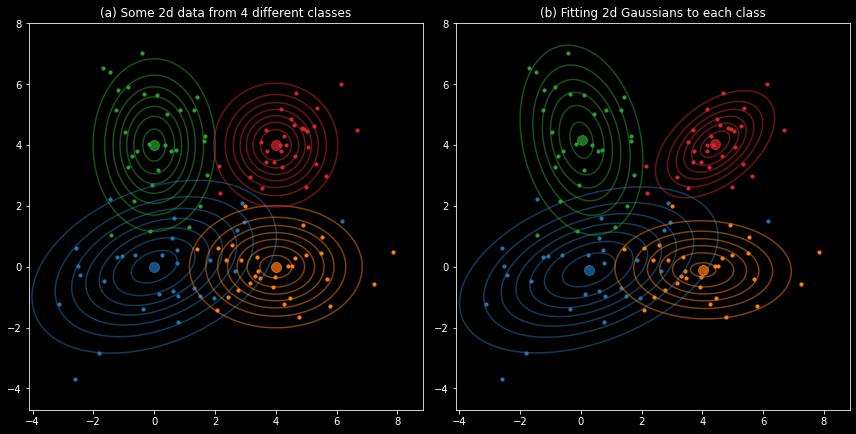

In [6]:
from scipy.stats import multivariate_normal
from matplotlib.colors import TABLEAU_COLORS

# plot points and coutours of multivariate gaussians
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1.set_aspect('equal')
ax1.set_title(f"(a) Some 2d data from {len(samples)} different classes")
for x, mean, cov, c in zip(samples, means, covs, TABLEAU_COLORS):
    ax1.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax1.contour(xx, yy, multivariate_normal.pdf(xy, mean=mean, cov=cov), colors=c, alpha=0.5)
    ax1.plot(mean[0], mean[1], 'o', markersize=10, color=c, alpha=0.7)

ax2.set_aspect('equal')
ax2.set_title("(b) Fitting 2d Gaussians to each class")
for x, c in zip(samples, TABLEAU_COLORS):
    ax2.scatter(x[:, 0], x[:, 1], s=10, color=c)
    sample_mean = np.mean(x, axis=0) # sample mean
    sample_cov = np.cov(x, rowvar=False, bias=False) # sample covariance (unbiased)
    ax2.contour(xx, yy, multivariate_normal.pdf(xy, mean=sample_mean, cov=sample_cov), colors=c, alpha=0.5)
    ax2.plot(sample_mean[0], sample_mean[1], 'o', markersize=10, color=c, alpha=0.7)

fig.tight_layout()

### Figure 9.2: Gaussian discriminant analysis fit to data in Figure 9.1.

In [7]:
X = np.concatenate(samples, axis=0) # shape (sample_size * nclasses, 2)
y = np.concatenate(labels) # shape (sample_size * nclasses,)
X. shape, y.shape

((120, 2), (120,))

### (a) Unconstrained covariances induce quadratic decision boundaries.

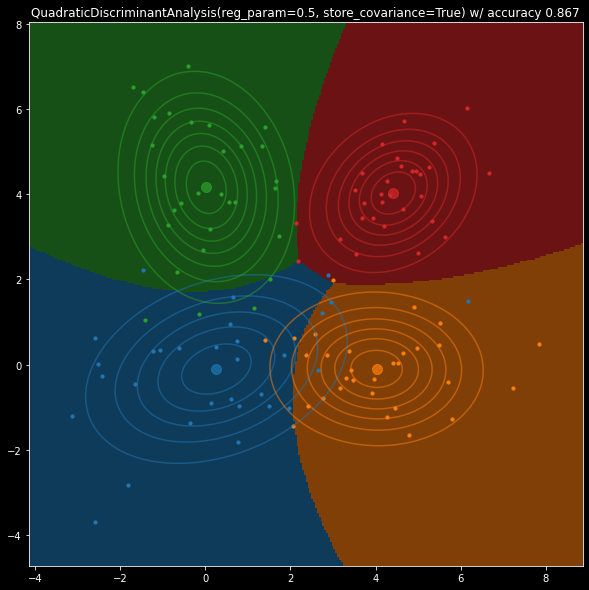

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

_, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

# fit model with samples
# reg_param controls between (unbiased) sample covariance (0) to the identity (1) 
clf = QuadraticDiscriminantAnalysis(reg_param=0.5, store_covariance=True)
clf.fit(X, y)
score = clf.score(X, y)
ax.set_title(f"{clf} w/ accuracy {score:.3f}")

Z = clf.predict(np.stack((xx.ravel(), yy.ravel()), axis=-1)) # shape (sample_size * nclasses,)
ax.pcolormesh(xx, yy, Z.reshape(xx.shape), alpha=0.5, cmap='tab10', vmax=len(TABLEAU_COLORS))

# plot boundaries
# from sklearn.preprocessing import OneHotEncoder
# for z_p in OneHotEncoder(sparse=False).fit_transform(Z[:,np.newaxis]).T:
#     ax.contour(xx, yy, z_p.reshape(xx.shape), levels=[0.5], linewidths=2, colors='yellow')

# plot points and coutours of multivariate gaussians w/ sample means and sample covariance (unbiased)
for x, mean, cov, c in zip(samples, clf.means_, clf.covariance_, TABLEAU_COLORS):
    ax.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax.contour(xx, yy, multivariate_normal.pdf(xy, mean=mean, cov=cov), colors=c, alpha=0.5)
    ax.plot(mean[0], mean[1], 'o', markersize=10, color=c, alpha=0.7)

In [9]:
# clf.covariance_ is the unbiased sample covariance satisfying 
[cov == V @ np.diag(S2) @ V.T for cov, V, S2 in zip(clf.covariance_, clf.rotations_, clf.scalings_)]

[array([[ True,  True],
        [ True,  True]]),
 array([[ True,  True],
        [ True,  True]]),
 array([[ True,  True],
        [ True,  True]]),
 array([[ True,  True],
        [ True,  True]])]

### (b) Tied covariances induce linear decision boundaries. 

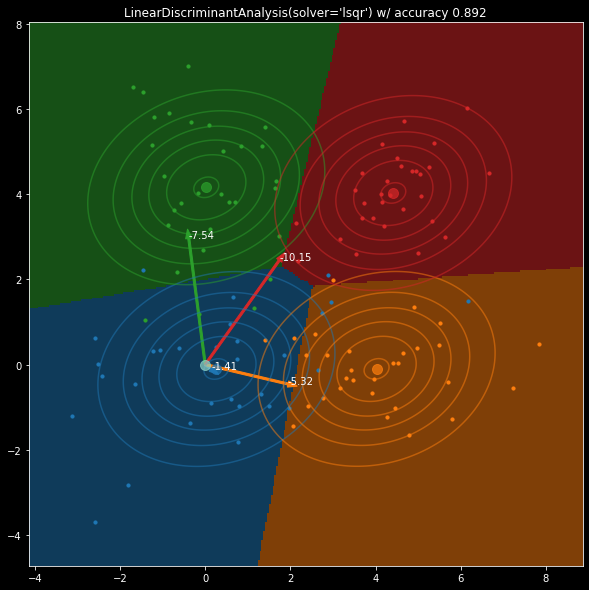

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

_, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

# fit model with samples
clf = LinearDiscriminantAnalysis(solver='lsqr')
clf.fit(X, y)
score = clf.score(X, y)
ax.set_title(f"{clf} w/ accuracy {score:.3f}")

# plot boundaries
Z = clf.predict(np.stack((xx.ravel(), yy.ravel()), axis=-1)) # shape (sample_size * nclasses,)
ax.pcolormesh(xx, yy, Z.reshape(xx.shape), alpha=0.5, cmap='tab10', vmax=len(TABLEAU_COLORS))

# plot points and coutours of multivariate gaussians w/ sample means and sample covariance (unbiased)
for x, mean, c in zip(samples, clf.means_, TABLEAU_COLORS):
    cov = clf.covariance_ # same covariance for all classes
    ax.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax.contour(xx, yy, multivariate_normal.pdf(xy, mean=mean, cov=cov), colors=c, alpha=0.5)
    ax.plot(mean[0], mean[1], 'o', markersize=10, color=c, alpha=0.7)

if len(clf.classes_) > 2:
    ax.plot(0, 0, 'o', markersize=10, alpha=0.7)
    for mean, coef, intercept, c in zip(clf.means_, clf.coef_, clf.intercept_, TABLEAU_COLORS):
        ax.arrow(0, 0, coef[0], coef[1], width=0.05, color=c)
        ax.text(coef[0], coef[1], f"{intercept:.2f}", horizontalalignment='left')
else:
    ax.plot(0, 0, 'o', markersize=10, alpha=0.7)
    ax.arrow(0, 0, coef[0], coef[1], width=0.05)
    ax.text(coef[0], coef[1], f"{intercept:.2f}", horizontalalignment='left')

### (c) Fisher's Linear Discriminant Analysis (FLDA) 

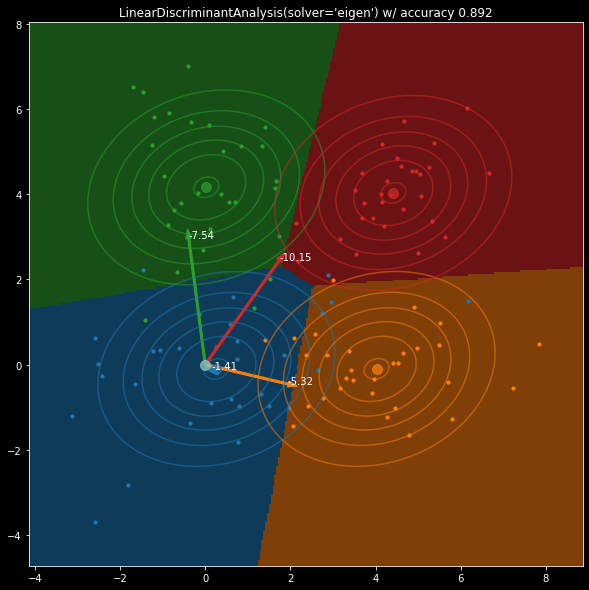

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

_, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

# fit model with samples
clf = LinearDiscriminantAnalysis(solver='eigen')
clf.fit(X, y)
score = clf.score(X, y)
ax.set_title(f"{clf} w/ accuracy {score:.3f}")

# plot boundaries
Z = clf.predict(np.stack((xx.ravel(), yy.ravel()), axis=-1)) # shape (sample_size * nclasses,)
ax.pcolormesh(xx, yy, Z.reshape(xx.shape), alpha=0.5, cmap='tab10', vmax=len(TABLEAU_COLORS))

# plot points and coutours of multivariate gaussians w/ sample means and sample covariance (unbiased)
for x, mean, c in zip(samples, clf.means_, TABLEAU_COLORS):
    cov = clf.covariance_ # same covariance for all classes
    ax.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax.contour(xx, yy, multivariate_normal.pdf(xy, mean=mean, cov=cov), colors=c, alpha=0.5)
    ax.plot(mean[0], mean[1], 'o', markersize=10, color=c, alpha=0.7)

if len(clf.classes_) > 2:
    ax.plot(0, 0, 'o', markersize=10, alpha=0.7)
    for mean, coef, intercept, c in zip(clf.means_, clf.coef_, clf.intercept_, TABLEAU_COLORS):
        ax.arrow(0, 0, coef[0], coef[1], width=0.05, color=c)
        ax.text(coef[0], coef[1], f"{intercept:.2f}", horizontalalignment='left')
else:
    ax.plot(0, 0, 'o', markersize=10, alpha=0.7)
    ax.arrow(0, 0, coef[0], coef[1], width=0.05)
    ax.text(coef[0], coef[1], f"{intercept:.2f}", horizontalalignment='left')

### (d) scikit-learn's Linear Discriminant Analysis using Two SVDs

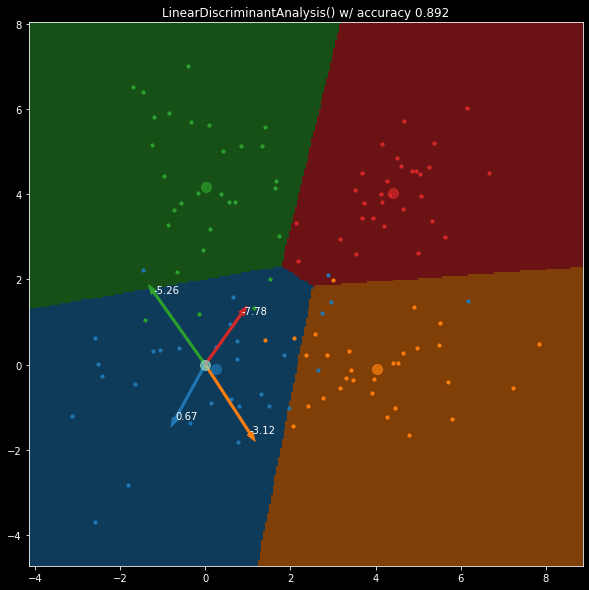

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

_, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

# fit model with samples
clf = LinearDiscriminantAnalysis(solver='svd') # default
clf.fit(X, y)
score = clf.score(X, y)
ax.set_title(f"{clf} w/ accuracy {score:.3f}")

# plot boundaries
Z = clf.predict(np.stack((xx.ravel(), yy.ravel()), axis=-1)) # shape (sample_size * nclasses,)
ax.pcolormesh(xx, yy, Z.reshape(xx.shape), alpha=0.5, cmap='tab10', vmax=len(TABLEAU_COLORS))

# plot points and coutours of multivariate gaussians w/ sample means and sample covariance (unbiased)
for x, mean, c in zip(samples, clf.means_, TABLEAU_COLORS):
    ax.scatter(x[:, 0], x[:, 1], s=10, color=c)
    ax.plot(mean[0], mean[1], 'o', markersize=10, color=c, alpha=0.7)

if len(clf.classes_) > 2:
    ax.plot(0, 0, 'o', markersize=10, alpha=0.7)
    for mean, coef, intercept, c in zip(clf.means_, clf.coef_, clf.intercept_, TABLEAU_COLORS):
        ax.arrow(0, 0, coef[0], coef[1], width=0.05, color=c)
        ax.text(coef[0], coef[1], f"{intercept:.2f}", horizontalalignment='left')
else:
    ax.plot(0, 0, 'o', markersize=10, alpha=0.7)
    ax.arrow(0, 0, coef[0], coef[1], width=0.05)
    ax.text(coef[0], coef[1], f"{intercept:.2f}", horizontalalignment='left')